In [1]:
# Imports: 
from pinkrigs_tools.dataset.query import load_data, queryCSV
from pinkrigs_tools.utils.spk_utils import bombcell_sort_units
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from datetime import datetime
import time
import seaborn as sns
from scipy import stats, signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from neuropixel_utils import *
from correlation_utils import *
%load_ext autoreload
%autoreload 2

# Experiment parameters - change to the current experiment:
SUBJECT = 'AV049'
EXP_DATE = '2023-07-27'
EXP_NUM = '2'

exp_kwargs = {
    'subject': [SUBJECT],
    'expDate': EXP_DATE,
    'expNum': EXP_NUM,
}

# Defined DLC folder path and output directory: 
dlc_folder = f"C:\\Users\\Experiment\\Projects\\video_conversions\\subjects\\{SUBJECT}\\{EXP_DATE}_{EXP_NUM}\\DLC"
output_folder = os.path.join(dlc_folder, "neuropixel_analysis")
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Define ONE data to load: 
data_name_dict = {'events':{'_av_trials':'table'}}
recordings = load_data(data_name_dict=data_name_dict,**exp_kwargs)
exp_info = queryCSV(**exp_kwargs)
print(f"Analysis for: {SUBJECT} on {EXP_DATE} experiment {EXP_NUM}")
print(f"Experiment folder:", exp_info['expFolder'].iloc[0], 
      "Ephys folder:", exp_info['ephysPathProbe0'].iloc[0])

Analysis for: AV049 on 2023-07-27 experiment 2
Experiment folder: \\zaru.cortexlab.net\Subjects\AV049\2023-07-27\2 Ephys folder: \\zaru.cortexlab.net\Subjects\AV049\2023-07-27\ephys\AV049_2023-07-27_freely-moving_g0\AV049_2023-07-27_freely-moving_g0_imec0


In [2]:
# load variables from saved results:
loaded_results = load_analysis_results(output_folder=output_folder)

results = loaded_results['results']
freq_results = loaded_results['freq_results']
spectrum_results = loaded_results['spectrum_results']
smoothed_results = loaded_results['smoothed_results']
neural_sleep_csv = loaded_results['neural_sleep_csv']
np_results = loaded_results['np_results']
pca_results = loaded_results['pca_results']
matrix_results = loaded_results['matrix_results']
state_corr_results = loaded_results['state_corr_results']
rrf_results = loaded_results['rrf_results']
population_corr_results = loaded_results['population_corr_results']



Using most recent metadata file: 20250624_140901_experiment_metadata.json
Loading results from 2025-06-24 14:09:53 for subject AV049
Loading results... loaded from .pkl (dict with 2 keys)
Loading freq_results... loaded from .pkl (dict with 2 keys)
Loading spectrum_results... loaded from .pkl (dict with 1 keys)
Loading smoothed_results... loaded from .pkl (dict with 23 keys)
Loading neural_sleep_csv... recorded path: C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-07-27_2\DLC\neuropixel_analysis\sleep_times.csv
Loading np_results... loaded from .pkl (dict with 1 keys)
Loading pca_results... loaded from .npz (dict with 6 keys)
Loading matrix_results... loaded from .pkl (dict with 6 keys)
Loading state_corr_results... loaded from .pkl (dict with 6 keys)
Loading rrf_results... loaded from .npz (dict with 8 keys)
Loading population_corr_results... loaded from .npz (dict with 7 keys)
Loading population_corr_results_split... loaded from .npz (dict with 10 keys)
Loading matr

In [18]:
def combined_visualization(results, freq_results, np_results, spectrum_results, 
                          dlc_folder, output_dir=None, save_plots=False, smoothed_results=None, pca_results=None, show_sleep_in_delta=False):
    """
    Create a combined visualization of sleep-wake activity, power spectrum analysis,
    and behavioral data using pre-computed results.
    
    Parameters:
    -----------
    results : dict
        Original dictionary containing results from process_spike_data()
    freq_results : dict
        Original high temporal resolution data for frequency analysis
    np_results : dict
        Results from analyze_sleep_wake_activity()
    spectrum_results : dict
        Results from analyze_power_spectrum()
    dlc_folder : str
        Path to the DLC folder containing behavioral data
    output_dir : str, optional
        Directory to save plots to (default: None)
    save_plots : bool, optional
        Whether to save plots (default: False)
    show_sleep_in_delta : bool, optional
        Whether to show sleep periods in the delta power plot (default: False)
        
    Returns:
    --------
    None
    """
    
    # Check which probes have the required data
    valid_probes = []
    for probe in results:
        if 'sleep_bout_mapping' not in results[probe]:
            print(f"No sleep bout mapping found for {probe}. Skipping.")
            continue
        if 'cluster_quality' not in results[probe]:
            print(f"No quality labels found for {probe}. Skipping.")
            continue
        valid_probes.append(probe)
    
    if not valid_probes:
        print("No valid probes found with required data.")
        return
    
    # Use the first probe's time bins and sleep bout info as reference
    reference_probe = valid_probes[0]
    time_bins = results[reference_probe]['time_bins']
    sleep_bouts = results[reference_probe]['sleep_bout_mapping']
    
    # Create a mask for time bins that fall within any sleep period
    sleep_mask = np.zeros(len(time_bins), dtype=bool)
    for _, bout in sleep_bouts.iterrows():
        start_idx = bout['start_bin_index']
        end_idx = bout['end_bin_index']
        sleep_mask[start_idx:end_idx+1] = True

    # Time extent for all plots
    time_extent = [time_bins[0], time_bins[-1]]
    
    # Load behavioral data from DLC pixel_difference folder
    pixel_diff_path = os.path.join(dlc_folder, "pixel_difference")
    
    # Find the CSV file containing pixel differences
    pixel_diff_files = [f for f in os.listdir(pixel_diff_path) 
                      if f.endswith('.csv') and 'pixel_differences' in f]
    
    if not pixel_diff_files:
        print(f"No pixel difference CSV found in {pixel_diff_path}")
        behavior_data = None
    else:
        # Use the first matching file
        pixel_diff_file = os.path.join(pixel_diff_path, pixel_diff_files[0])
        try:
            behavior_data = pd.read_csv(pixel_diff_file)
            print(f"Loaded behavioral data from {pixel_diff_file}")
            
            # Check if the required column exists
            if 'smoothed_difference' not in behavior_data.columns or 'time_sec' not in behavior_data.columns:
                print(f"Required columns not found in {pixel_diff_file}")
                print(f"Available columns: {list(behavior_data.columns)}")
                behavior_data = None
            
        except Exception as e:
            print(f"Error loading behavioral data: {e}")
            behavior_data = None
    
    # Create figure with 5 subplots with custom height ratios (removed PC1 plot)
    fig = plt.figure(figsize=(16, 20))
    gs = gridspec.GridSpec(5, 1, height_ratios=[1, 3, 1, 3, 1.5], figure=fig)
    
    # ================ PLOT 1: BEHAVIOR DATA (NO SLEEP PERIODS) ================
    ax_behav = fig.add_subplot(gs[0])
    
    if behavior_data is not None:
        # Extract time and smoothed difference data
        time_sec = behavior_data['time_sec'].values
        smoothed_diff = behavior_data['smoothed_difference'].values
        
        # Convert to thousands for better axis labels
        smoothed_diff_scaled = smoothed_diff / 1000
        
        # Handle missing values - create separate segments to plot
        valid_mask = ~np.isnan(smoothed_diff_scaled)
        gaps = np.where(np.diff(valid_mask.astype(int)) != 0)[0] + 1
        segments = np.split(np.arange(len(valid_mask)), gaps)
        
        # Plot each continuous segment separately (NO SLEEP PERIODS)
        for segment in segments:
            if len(segment) > 0 and valid_mask[segment[0]]:  # Only plot valid segments
                ax_behav.plot(time_sec[segment], smoothed_diff_scaled[segment], 'k-', linewidth=1)
        
        # Remove title, grid, and top/right spines
        ax_behav.set_ylabel('Pixel\nDifference', fontsize=22)
        ax_behav.set_xlim(time_extent)
        ax_behav.spines['top'].set_visible(False)
        ax_behav.spines['right'].set_visible(False)
        ax_behav.tick_params(axis='x', labelsize=18, which='both')
        ax_behav.tick_params(axis='y', labelsize=18, which='both')
    else:
        ax_behav.text(0.5, 0.5, 'Behavioral data not available', 
                    ha='center', va='center', transform=ax_behav.transAxes)
        ax_behav.set_xlim(time_extent)
        ax_behav.set_ylabel('Pixel\nDifference', fontsize=14)
        ax_behav.spines['top'].set_visible(False)
        ax_behav.spines['right'].set_visible(False)
        ax_behav.tick_params(axis='x', labelsize=12, which='both')
        ax_behav.tick_params(axis='y', labelsize=12, which='both')
    
    # ================ PLOT 2: CLUSTER ACTIVITY HEATMAP (NO SLEEP INDICATORS) ================
    ax1 = fig.add_subplot(gs[1], sharex=ax_behav)
    
    # Get sorted normalized counts from np_results if available
    if 'merged' in np_results and 'modulation_index' in np_results['merged']:
        # Extract data from np_results
        merged_data = np_results['merged']
        modulation_index = merged_data['modulation_index']
        
        # Sort by modulation index
        sorted_indices = np.argsort(modulation_index)
        
        # Get or reconstruct normalized counts
        if 'counts' in merged_data:
            sorted_normalized_counts = merged_data['counts'][sorted_indices]
        else:
            # Need to reconstruct from original data
            # Collect data from all probes
            all_counts = []
            for probe in valid_probes:
                # Filter out noise clusters, keep good and mua
                counts, _, _ = filter_clusters_by_quality(
                    results, probe, include_qualities=['good', 'mua']
                )
                all_counts.append(counts)
                
            merged_counts = np.vstack(all_counts)
            
            # Normalize and sort
            normalized_counts = np.zeros_like(merged_counts, dtype=float)
            for i in range(merged_counts.shape[0]):
                cluster_counts = merged_counts[i, :]
                p95 = np.percentile(cluster_counts, 95)
                
                # Avoid division by zero
                if p95 > 0:
                    normalized_counts[i, :] = cluster_counts / p95
                else:
                    normalized_counts[i, :] = cluster_counts
                    
            sorted_normalized_counts = normalized_counts[sorted_indices]
    else:
        print("Warning: modulation_index not found in np_results. Cannot create sorted heatmap.")
        sorted_normalized_counts = None
        
    if sorted_normalized_counts is not None:
        # Plot the heatmap (NO SLEEP INDICATORS)
        extent = [time_extent[0], time_extent[1], 0, sorted_normalized_counts.shape[0]]
        vmax_threshold = np.percentile(sorted_normalized_counts, 95)
        
        im1 = ax1.matshow(sorted_normalized_counts, aspect='auto', extent=extent, cmap='binary', 
                        interpolation='none', origin='lower', vmin=0, vmax=vmax_threshold)
        
        ax1.set_ylabel('Clusters', fontsize=22)
        ax1.set_xlim(time_extent)
        
        # Move X axis ticks to bottom
        ax1.xaxis.tick_bottom()
        ax1.tick_params(axis='x', labelsize=18, which='both')
        ax1.tick_params(axis='y', labelsize=18, which='both')
    
    # ================ PLOT 3: AVERAGE ACTIVITY (NO SLEEP PERIODS) ================
    ax2 = fig.add_subplot(gs[2], sharex=ax_behav)
    
    # Get or calculate mean activity
    if 'merged' in np_results and 'mean_activity' in np_results['merged']:
        mean_activity = np_results['merged']['mean_activity']
    else:
        # Need to calculate from original data
        all_counts = []
        for probe in valid_probes:
            # Filter out noise clusters, keep good and mua
            counts, _, _ = filter_clusters_by_quality(
                results, probe, include_qualities=['good', 'mua']
            )
            all_counts.append(counts)
            
        if all_counts:
            merged_counts = np.vstack(all_counts)
            mean_activity = np.mean(merged_counts, axis=0)
        else:
            mean_activity = None
            print("Warning: No valid clusters found to calculate mean activity")
    
    if mean_activity is not None:
        # Calculate reasonable y-limits with padding
        buffer_factor = 0.15
        data_range = np.max(mean_activity) - np.min(mean_activity)
        buffer_amount = data_range * buffer_factor
        y_max = np.max(mean_activity) + buffer_amount
        y_min = np.min(mean_activity) - buffer_amount
        
        ax2.plot(time_bins, mean_activity, color='black', linewidth=1)
        ax2.set_ylim(y_min, y_max)
        
        # Remove title, grid, and top/right spines
        ax2.set_ylabel('Mean\nspike count', fontsize=22)
        ax2.set_xlim(time_extent)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.tick_params(axis='x', labelsize=18, which='both')
        ax2.tick_params(axis='y', labelsize=18, which='both')
    
    # ================ PLOT 4: POWER SPECTRUM ================
    ax4 = fig.add_subplot(gs[3], sharex=ax_behav)
    
    # Get or calculate power spectrum
    if 'merged' in spectrum_results and 'power_spectrum' in spectrum_results['merged']:
        spectrum_data = spectrum_results['merged']
        frequencies = spectrum_data['frequencies']
        Sxx = spectrum_data['power_spectrum']
        
        # Convert to dB if not already
        if not np.any(Sxx < 0):  # Assuming it's not already in dB
            Sxx_db = 10 * np.log10(Sxx + 1e-10)
        else:
            Sxx_db = Sxx
        
        # Apply frequency filtering
        freq_range = (0, 30)
        freq_mask = (frequencies >= freq_range[0]) & (frequencies <= freq_range[1])
        frequencies_filtered = frequencies[freq_mask]
        Sxx_db_filtered = Sxx_db[freq_mask, :]
    else:
        print("Warning: power_spectrum not found in spectrum_results. Cannot create spectrogram.")
        Sxx_db_filtered = None
        frequencies_filtered = None
    
    if Sxx_db_filtered is not None and frequencies_filtered is not None:
        # Calculate power limits
        power_5th = np.percentile(Sxx_db_filtered, 5)
        power_95th = np.percentile(Sxx_db_filtered, 95)
        vmin = power_5th - 5
        vmax = power_95th + 5
        
        # Get frequency time bins
        if 'times' in spectrum_data:
            spec_times = spectrum_data['times']
            # Calculate spectrogram extent
            spec_extent = [time_extent[0], time_extent[1], frequencies_filtered[0], frequencies_filtered[-1]]
        else:
            # Retrieve from freq_results
            freq_time_bins = freq_results[reference_probe]['time_bins']
            spec_extent = [freq_time_bins[0], freq_time_bins[-1], frequencies_filtered[0], frequencies_filtered[-1]]
        
        im3 = ax4.matshow(Sxx_db_filtered, aspect='auto', origin='lower', 
                        extent=spec_extent, cmap='viridis',
                        vmin=vmin, vmax=vmax)
        
        # Remove title and move X axis ticks to bottom
        ax4.set_ylabel('Frequency (Hz)', fontsize=22)
        ax4.set_xlim(time_extent)  # Use the same time extent as other plots
        ax4.xaxis.tick_bottom()
        ax4.tick_params(axis='x', labelsize=18, which='both')
        ax4.tick_params(axis='y', labelsize=18, which='both')
    
    # ================ PLOT 5: FREQUENCY BAND POWER (OPTIONAL SLEEP PERIODS) ================
    ax5 = fig.add_subplot(gs[4], sharex=ax_behav)

    # Check if we have smoothed data available from the smoothed_results parameter
    band_powers = None
    smoothed_available = False
    filter_type = None
    
    # First check if smoothed_results is provided directly
    if smoothed_results is not None:
        # Try to determine which filter was used in save_sleep_periods_to_csv
        if output_dir:
            sleep_times_csv = os.path.join(output_dir, "sleep_times.csv")
            if os.path.exists(sleep_times_csv):
                try:
                    sleep_df = pd.read_csv(sleep_times_csv)
                    if 'filter' in sleep_df.columns and len(sleep_df) > 0:
                        filter_name = sleep_df['filter'].iloc[0]
                        if 'Savitzky-Golay' in filter_name:
                            filter_type = 'sg'
                            print("Using Savitzky-Golay filter for frequency band visualization")
                            if 'savitzky_golay' in smoothed_results:
                                band_powers = smoothed_results['savitzky_golay']
                                smoothed_available = True
                        elif 'MovingAverage' in filter_name or 'Moving Average' in filter_name:
                            filter_type = 'ma'
                            print("Using Moving Average filter for frequency band visualization")
                            if 'moving_average' in smoothed_results:
                                band_powers = smoothed_results['moving_average']
                                smoothed_available = True
                except Exception as e:
                    print(f"Error determining filter type: {e}")
    
    # Fall back to original if smoothed not available
    if not smoothed_available and 'merged' in spectrum_results and 'band_powers' in spectrum_results['merged']:
        band_powers = spectrum_results['merged']['band_powers']
        print("Using original band powers (smoothed data not available)")
    
    if band_powers is not None:
        # Get or calculate spectrogram times
        if 'times' in spectrum_results.get('merged', {}):
            spec_times = np.linspace(time_extent[0], time_extent[1], len(next(iter(band_powers.values()))))
        else:
            # Retrieve from freq_results
            freq_time_bins = freq_results[reference_probe]['time_bins']
            spec_times = np.linspace(freq_time_bins[0], freq_time_bins[-1], len(next(iter(band_powers.values()))))
        
        # Plot each band in black
        for band_name, power in band_powers.items():
            ax5.plot(spec_times, power, color='black', linewidth=1.5)
        
        # Optionally add sleep periods as shaded regions
        if show_sleep_in_delta:
            y_limits = ax5.get_ylim()
            for _, bout in sleep_bouts.iterrows():
                ax5.axvspan(bout['start_timestamp_s'], bout['end_timestamp_s'], 
                           alpha=0.2, color='lightblue')
            ax5.set_ylim(y_limits)  # Restore original y-limits
        
        # Remove title, grid, and top/right spines, format axes
        ax5.set_ylabel('Power (dB)', fontsize=22)
        ax5.set_xlabel('Time (s)', fontsize=26)
        ax5.legend(loc='upper right')
        ax5.set_xlim(time_extent)  # Use the same time extent as other plots
        ax5.spines['top'].set_visible(False)
        ax5.spines['right'].set_visible(False)
        ax5.tick_params(axis='x', labelsize=18, which='both')
        ax5.tick_params(axis='y', labelsize=18, which='both')
    
        for label in ax5.get_xticklabels():
            label.set_weight('bold')

    # Adjust layout to make better use of space now that colorbars are removed
    plt.subplots_adjust(hspace=0.4, left=0.06, right=0.98, top=0.96, bottom=0.05)
    
    # Save plot if requested
    if save_plots and output_dir:
        os.makedirs(output_dir, exist_ok=True)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"combined_sleep_wake_spectrum_analysis_{timestamp}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"Saved combined plot to: {filepath}")
    
    plt.show()

Loaded behavioral data from C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-07-27_2\DLC\pixel_difference\2023-07-27_2_AV049_topCam_pixel_differences.csv
Filtered probe0: kept 387 of 798 clusters
Filtered probe1: kept 354 of 690 clusters


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Filtered probe0: kept 387 of 798 clusters
Filtered probe1: kept 354 of 690 clusters
Using Savitzky-Golay filter for frequency band visualization
Saved combined plot to: C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-07-27_2\DLC\neuropixel_analysis\combined_sleep_wake_spectrum_analysis_20250626_154427.png


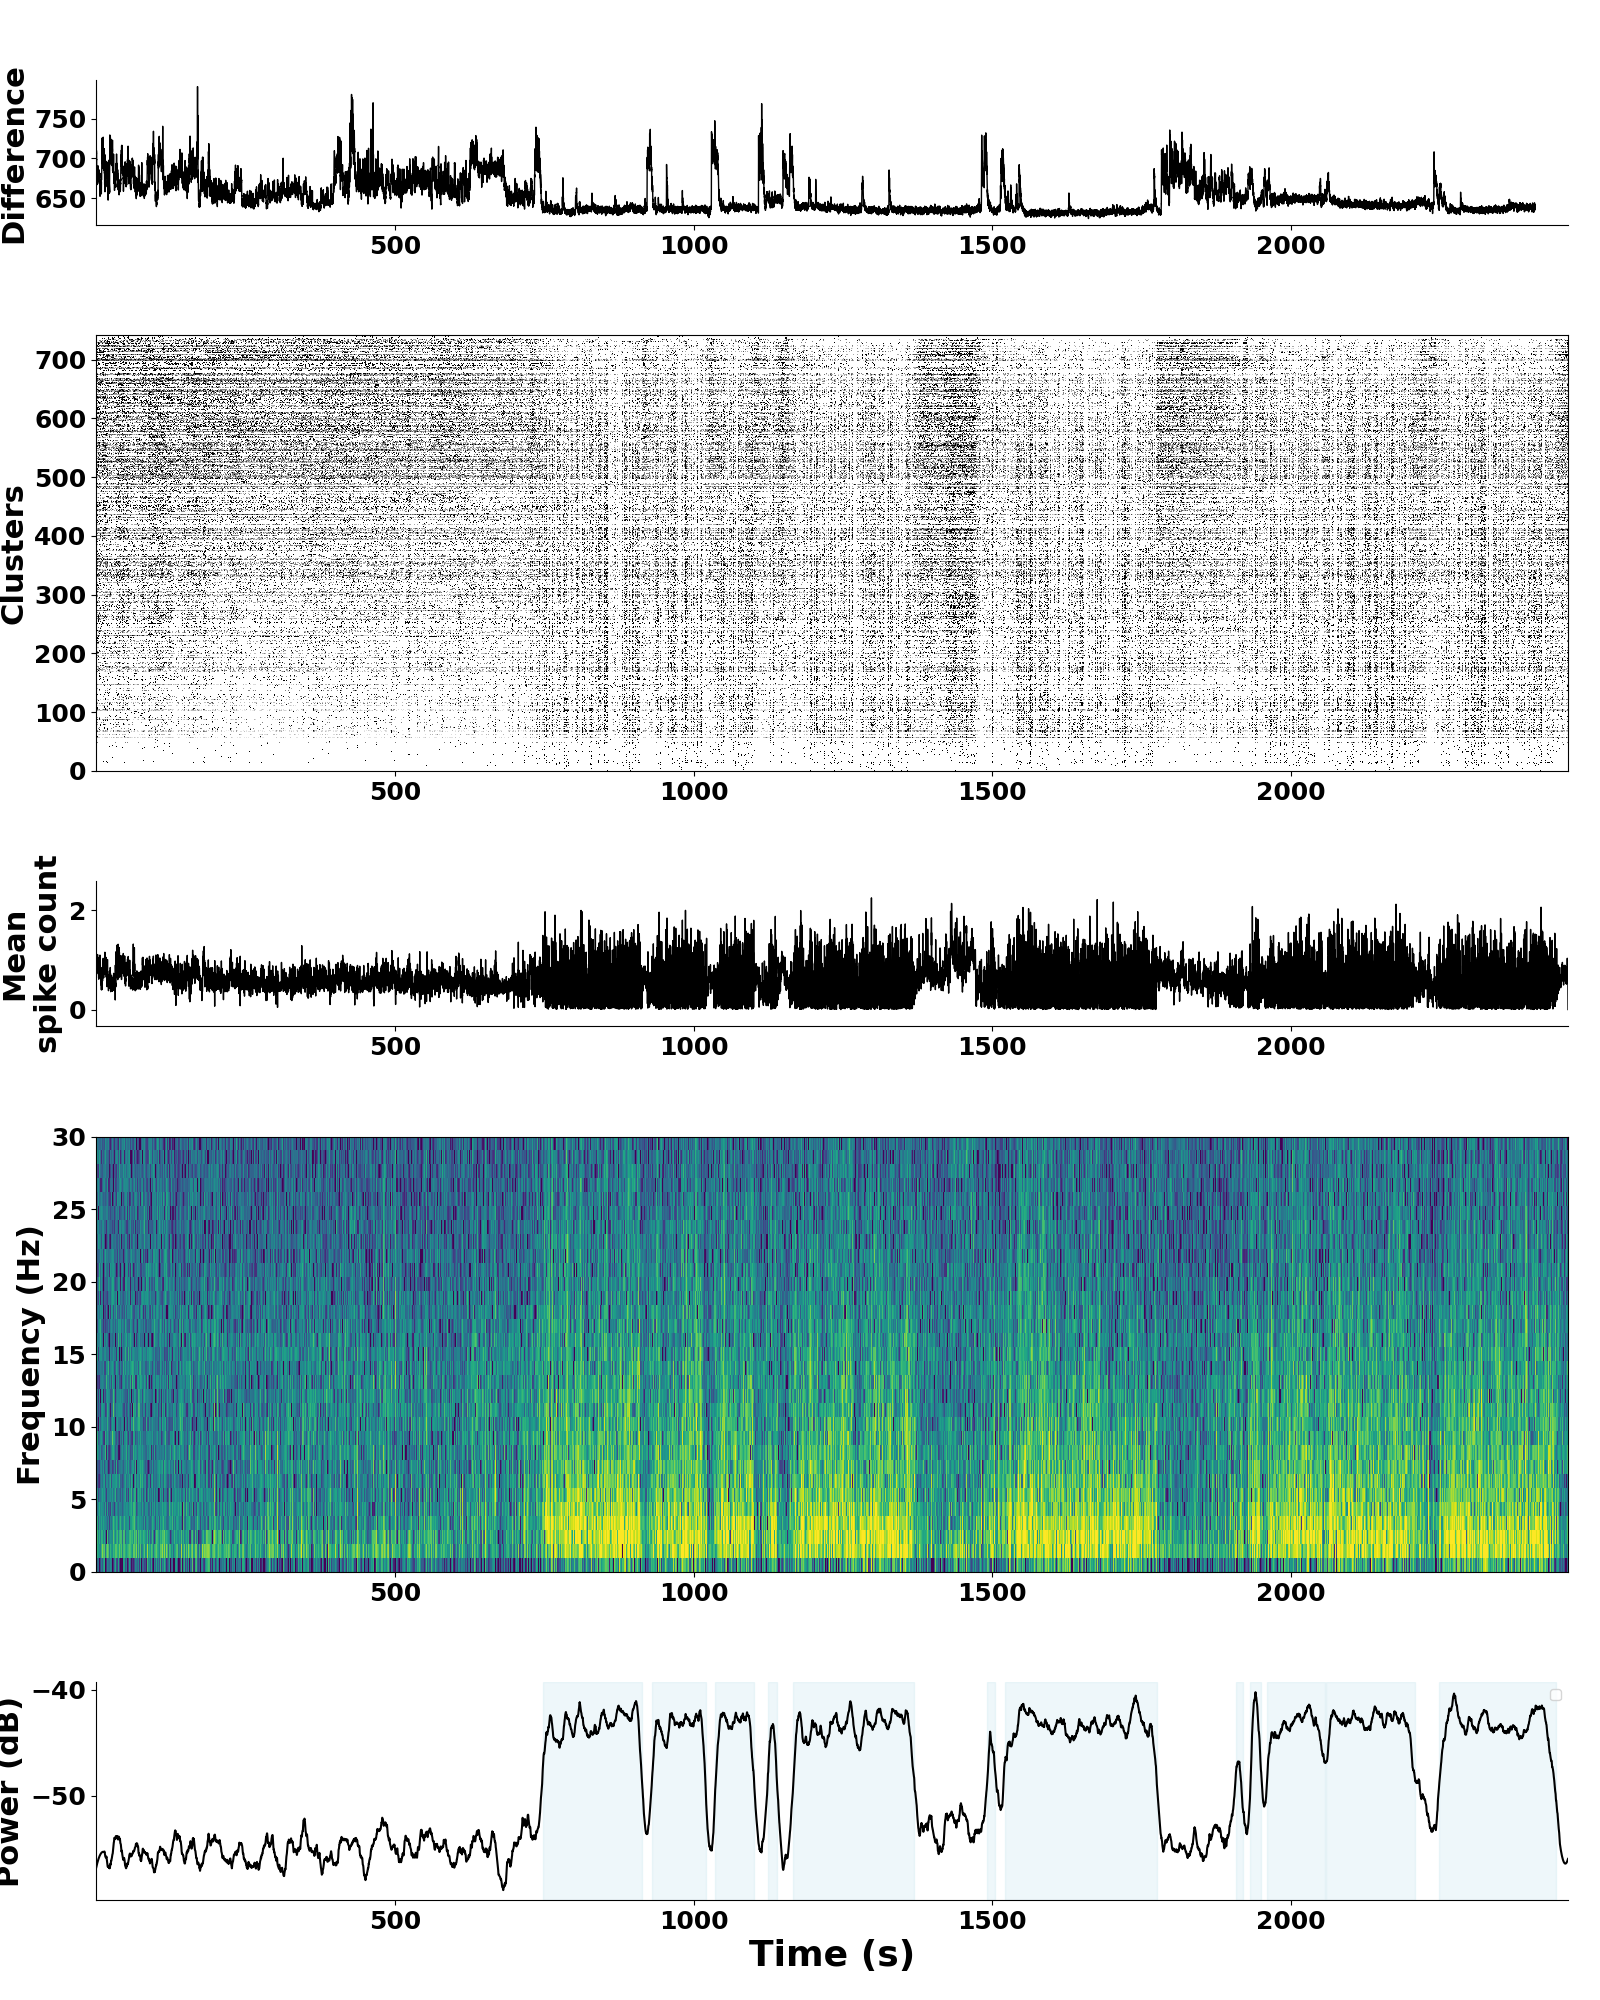

In [20]:
combined_visualization(
    results=results,
    freq_results=freq_results,
    np_results=np_results,
    spectrum_results=spectrum_results,
    dlc_folder=dlc_folder,
    output_dir=output_folder,
    save_plots=True,
    smoothed_results=smoothed_results,
    pca_results=pca_results,
    show_sleep_in_delta=True
)

In [ ]:
def analyze_cluster_state_and_stability(results, output_dir=None, save_plots=False, bin_size_s=120, 
                                       state_threshold=0.9, max_iterations=1000):
    """
    Combined analysis of cluster state distribution and neuronal stability using pooled data from all probes.
    Creates both the state distribution plot and stability scatter plots in a single analysis.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing results from process_spike_data(), with sleep bout mapping and bombcell classification
    output_dir : str, optional
        Directory to save plots to (default: None)
    save_plots : bool, optional
        Whether to save plots (default: False)
    bin_size_s : float, optional
        Size of time bins in seconds for state analysis (default: 120s = 2 minutes)
    state_threshold : float, optional
        Threshold for classifying a bin as sleep/wake (default: 0.9 or 90%)
    max_iterations : int, optional
        Maximum number of iterations for random assignment (default: 1000)
        
    Returns:
    --------
    dict
        Dictionary containing both state distribution and stability metrics for merged probes
    """
    # Convert threshold from percentage to fraction if needed
    if state_threshold > 1:
        state_threshold = state_threshold / 100
    
    # Check which probes have the required data
    valid_probes = []
    for probe in results:
        if 'sleep_bout_mapping' not in results[probe]:
            print(f"No sleep bout mapping found for {probe}. Skipping.")
            continue
        if 'cluster_quality' not in results[probe]:
            print(f"No quality labels found for {probe}. Skipping.")
            continue
        valid_probes.append(probe)
    
    if not valid_probes:
        print("No valid probes found with required data.")
        return {}
    
    # Use the first probe's time bins and sleep bout info as reference
    reference_probe = valid_probes[0]
    time_bins = results[reference_probe]['time_bins']
    sleep_bouts = results[reference_probe]['sleep_bout_mapping']
    original_bin_size = time_bins[1] - time_bins[0]
    
    # Create a mask for time bins that fall within any sleep period
    sleep_mask = np.zeros(len(time_bins), dtype=bool)
    for _, bout in sleep_bouts.iterrows():
        start_idx = bout['start_bin_index']
        end_idx = bout['end_bin_index']
        sleep_mask[start_idx:end_idx+1] = True

    wake_mask = ~sleep_mask
    
    # Collect and merge data from all probes
    all_counts = []
    all_cluster_ids = []
    all_min_length = float('inf')
    
    # First pass: determine minimum length and collect data
    for probe in valid_probes:
        # Filter out noise clusters, keep good and mua
        counts, cluster_ids, quality_mask = filter_clusters_by_quality(
            results, probe, include_qualities=['good', 'mua']
        )
        
        if counts.shape[0] > 0:
            all_min_length = min(all_min_length, counts.shape[1])
            all_counts.append(counts)
            all_cluster_ids.extend([(probe, cid) for cid in cluster_ids])
    
    if not all_counts:
        print("No valid clusters found after filtering.")
        return {}
    
    # Second pass: truncate all arrays to minimum length
    for i in range(len(all_counts)):
        all_counts[i] = all_counts[i][:, :all_min_length]
    
    # Merge counts from all probes
    merged_counts = np.vstack(all_counts)
    
    # Adjust time_bins and sleep_mask to match truncated data
    time_bins = time_bins[:all_min_length]
    sleep_mask = sleep_mask[:all_min_length]
    wake_mask = ~sleep_mask
    
    # Normalize each cluster's firing rate by its 95th percentile
    normalized_counts = np.zeros_like(merged_counts, dtype=float)
    for i in range(merged_counts.shape[0]):
        cluster_counts = merged_counts[i, :]
        p95 = np.percentile(cluster_counts, 95)
        
        # Avoid division by zero
        if p95 > 0:
            normalized_counts[i, :] = cluster_counts / p95
        else:
            normalized_counts[i, :] = cluster_counts
    
    # Calculate how many original bins fit into our new larger bins
    bins_per_large_bin = int(bin_size_s / original_bin_size)
    num_large_bins = len(time_bins) // bins_per_large_bin
    
    if num_large_bins == 0:
        print(f"Warning: Recording too short for {bin_size_s}s bins. Try a smaller bin size.")
        return {}
    
    # Initialize arrays to store state and firing rates for each large bin
    large_bin_states = []
    large_bin_times = []
    large_bin_firing_rates = np.zeros((normalized_counts.shape[0], num_large_bins))
    
    # Process each large bin
    for i in range(num_large_bins):
        start_idx = i * bins_per_large_bin
        end_idx = min((i + 1) * bins_per_large_bin, len(time_bins))
        
        # Calculate bin center time
        bin_center = np.mean(time_bins[start_idx:end_idx])
        large_bin_times.append(bin_center)
        
        # Calculate state for this bin
        sleep_fraction = np.sum(sleep_mask[start_idx:end_idx]) / (end_idx - start_idx)
        
        if sleep_fraction >= state_threshold:
            large_bin_states.append('Sleep')
        elif sleep_fraction <= (1 - state_threshold):
            large_bin_states.append('Wake')
        else:
            large_bin_states.append('Mixed')
        
        # Calculate normalized firing rate for each cluster in this bin
        for j in range(normalized_counts.shape[0]):
            normalized_activity_in_bin = np.mean(normalized_counts[j, start_idx:end_idx])
            large_bin_firing_rates[j, i] = normalized_activity_in_bin
    
    # Convert to arrays for easier manipulation
    large_bin_times = np.array(large_bin_times)
    large_bin_states = np.array(large_bin_states)
    
    # === STATE DISTRIBUTION ANALYSIS ===
    # Collect data for plotting
    plot_data = []
    for i, cluster_id in enumerate(all_cluster_ids):
        sleep_rates = large_bin_firing_rates[i, [idx for idx, state in enumerate(large_bin_states) if state == 'Sleep']]
        wake_rates = large_bin_firing_rates[i, [idx for idx, state in enumerate(large_bin_states) if state == 'Wake']]
        
        # Calculate average normalized firing rate across bins for each state
        if len(sleep_rates) > 0:
            sleep_avg_rate = np.mean(sleep_rates)
            plot_data.append({
                'cluster_id': cluster_id,
                'state': 'Sleep',
                'firing_rate': sleep_avg_rate
            })
            
        if len(wake_rates) > 0:
            wake_avg_rate = np.mean(wake_rates)
            plot_data.append({
                'cluster_id': cluster_id,
                'state': 'Wake',
                'firing_rate': wake_avg_rate
            })
    
    # Convert to DataFrame for seaborn
    df_plot = pd.DataFrame(plot_data)
    
    # === STABILITY ANALYSIS ===
    # Identify recording midpoint
    midpoint_time = (time_bins[0] + time_bins[-1]) / 2
    
    # Create bin groups
    first_half_sleep_bins = np.where((large_bin_times < midpoint_time) & (large_bin_states == 'Sleep'))[0]
    first_half_wake_bins = np.where((large_bin_times < midpoint_time) & (large_bin_states == 'Wake'))[0]
    second_half_sleep_bins = np.where((large_bin_times >= midpoint_time) & (large_bin_states == 'Sleep'))[0]
    second_half_wake_bins = np.where((large_bin_times >= midpoint_time) & (large_bin_states == 'Wake'))[0]
    
    # Print bin distribution
    print(f"\nBin distribution for merged probes:")
    print(f"First half sleep bins: {len(first_half_sleep_bins)}")
    print(f"First half wake bins: {len(first_half_wake_bins)}")
    print(f"Second half sleep bins: {len(second_half_sleep_bins)}")
    print(f"Second half wake bins: {len(second_half_wake_bins)}")
    
    # Try to find a balanced split for stability analysis
    all_first_half_bins = np.concatenate([first_half_sleep_bins, first_half_wake_bins])
    all_second_half_bins = np.concatenate([second_half_sleep_bins, second_half_wake_bins])
    all_sleep_bins = np.concatenate([first_half_sleep_bins, second_half_sleep_bins])
    all_wake_bins = np.concatenate([first_half_wake_bins, second_half_wake_bins])
    
    # Define constraints
    success = False
    iteration = 0
    bin_assignment = np.zeros(num_large_bins, dtype=int)
    
    start_time = time.time()
    while not success and iteration < max_iterations:
        # Create a random assignment (1 = C1, 0 = C2)
        bin_assignment = np.zeros(num_large_bins, dtype=int)
        
        # Randomly assign bins to C1 (1) or C2 (0)
        all_bins = np.arange(num_large_bins)
        usable_bins = np.where(np.isin(all_bins, np.concatenate([all_first_half_bins, all_second_half_bins])))[0]
        
        if len(usable_bins) > 0:
            # Randomly select ~50% of bins for C1
            c1_bins = np.random.choice(usable_bins, size=len(usable_bins)//2, replace=False)
            bin_assignment[c1_bins] = 1
            
            # Check balance criteria
            if len(all_first_half_bins) > 0 and len(all_second_half_bins) > 0:
                first_half_in_c1 = np.sum(bin_assignment[all_first_half_bins])
                first_half_in_c2 = len(all_first_half_bins) - first_half_in_c1
                
                second_half_in_c1 = np.sum(bin_assignment[all_second_half_bins])
                second_half_in_c2 = len(all_second_half_bins) - second_half_in_c1
                
                # Check temporal balance (no more than 70% from one half)
                if first_half_in_c1 + second_half_in_c1 > 0 and first_half_in_c2 + second_half_in_c2 > 0:
                    temporal_balance_c1 = (first_half_in_c1 / (first_half_in_c1 + second_half_in_c1) <= 0.7 and
                                          second_half_in_c1 / (first_half_in_c1 + second_half_in_c1) <= 0.7)
                    
                    temporal_balance_c2 = (first_half_in_c2 / (first_half_in_c2 + second_half_in_c2) <= 0.7 and
                                          second_half_in_c2 / (first_half_in_c2 + second_half_in_c2) <= 0.7)
                    
                    # If both criteria are met, we're successful
                    if temporal_balance_c1 and temporal_balance_c2:
                        success = True
                    elif iteration > max_iterations//2:
                        success = True  # Accept less ideal split after many attempts
        
        iteration += 1
    
    end_time = time.time()
    
    if not success:
        print(f"Could not find a balanced split after {max_iterations} iterations. Using best available split.")
    else:
        print(f"Found balanced split after {iteration} iterations ({end_time - start_time:.2f}s)")
    
    # Calculate firing rates for each category
    c1_mask = bin_assignment == 1
    c2_mask = bin_assignment == 0
    
    # Calculate average normalized firing rates in C1 and C2 for each cluster
    c1_rates = np.zeros(normalized_counts.shape[0])
    c2_rates = np.zeros(normalized_counts.shape[0])
    
    # Also calculate sleep-wake difference for each category
    c1_sleep_rates = np.zeros(normalized_counts.shape[0])
    c1_wake_rates = np.zeros(normalized_counts.shape[0])
    c2_sleep_rates = np.zeros(normalized_counts.shape[0])
    c2_wake_rates = np.zeros(normalized_counts.shape[0])
    
    for i in range(normalized_counts.shape[0]):
        # Average normalized rates in each category
        c1_rates[i] = np.mean(large_bin_firing_rates[i, c1_mask]) if np.sum(c1_mask) > 0 else np.nan
        c2_rates[i] = np.mean(large_bin_firing_rates[i, c2_mask]) if np.sum(c2_mask) > 0 else np.nan
        
        # Sleep/wake rates in C1
        c1_sleep_mask = c1_mask & np.isin(np.arange(num_large_bins), all_sleep_bins)
        c1_wake_mask = c1_mask & np.isin(np.arange(num_large_bins), all_wake_bins)
        
        c1_sleep_rates[i] = np.mean(large_bin_firing_rates[i, c1_sleep_mask]) if np.sum(c1_sleep_mask) > 0 else np.nan
        c1_wake_rates[i] = np.mean(large_bin_firing_rates[i, c1_wake_mask]) if np.sum(c1_wake_mask) > 0 else np.nan
        
        # Sleep/wake rates in C2
        c2_sleep_mask = c2_mask & np.isin(np.arange(num_large_bins), all_sleep_bins)
        c2_wake_mask = c2_mask & np.isin(np.arange(num_large_bins), all_wake_bins)
        
        c2_sleep_rates[i] = np.mean(large_bin_firing_rates[i, c2_sleep_mask]) if np.sum(c2_sleep_mask) > 0 else np.nan
        c2_wake_rates[i] = np.mean(large_bin_firing_rates[i, c2_wake_mask]) if np.sum(c2_wake_mask) > 0 else np.nan
    
    # Calculate modulation
    c1_modulation = c1_wake_rates - c1_sleep_rates
    c2_modulation = c2_wake_rates - c2_sleep_rates
    
    # === COMBINED PLOTTING ===
    # Create figure with 3 subplots: swarm plot + 2 stability plots
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    # === PLOT 1: STATE DISTRIBUTION SWARM PLOT ===
    if not df_plot.empty:
        # Create swarm plot
        sns.swarmplot(data=df_plot, x='state', y='firing_rate', color='gray', alpha=0.7, size=5, ax=axes[0])
        
        # Add box plot over swarm plot
        sns.boxplot(data=df_plot, x='state', y='firing_rate', color='white', fliersize=0, width=0.5, 
                   boxprops={"facecolor": (.9, .9, .9, 0.5), "edgecolor": "black"}, ax=axes[0])
        
        # Perform statistical test
        sleep_rates_plot = df_plot[df_plot['state'] == 'Sleep']['firing_rate'].values
        wake_rates_plot = df_plot[df_plot['state'] == 'Wake']['firing_rate'].values
        
        if len(sleep_rates_plot) > 0 and len(wake_rates_plot) > 0:
            stat, p_value = stats.mannwhitneyu(sleep_rates_plot, wake_rates_plot)
            axes[0].set_title('State-Dependent Firing Rates', fontsize=14, fontweight='bold')
        else:
            axes[0].set_title('State-Dependent Firing Rates', fontsize=14, fontweight='bold')
    else:
        axes[0].text(0.5, 0.5, 'No data available for state analysis', 
                    ha='center', va='center', transform=axes[0].transAxes)
        axes[0].set_title('State-Dependent Firing Rates', fontsize=14, fontweight='bold')
    
    # Remove x-axis label and make y-axis label bigger
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Normalized Firing Rate', fontsize=12)
    axes[0].tick_params(axis='x', labelsize=12)
    axes[0].grid(True, axis='y', alpha=0.3)
    
    # === PLOT 2: STABILITY - FIRING RATE CONSISTENCY ===
    valid_mask = ~np.isnan(c1_rates) & ~np.isnan(c2_rates)
    
    if np.sum(valid_mask) > 1:
        # Get max value for axis scaling
        max_val = max(np.nanmax(c1_rates), np.nanmax(c2_rates))
        
        # Create scatter plot
        axes[1].scatter(c1_rates[valid_mask], c2_rates[valid_mask], alpha=0.7)
        
        # Add identity line
        axes[1].plot([0, max_val*1.1], [0, max_val*1.1], 'k--', alpha=0.7)
        
        # Add regression line
        slope, intercept, r_value, p_value_stability, std_err = stats.linregress(
            c1_rates[valid_mask], c2_rates[valid_mask]
        )
        
        x_vals = np.array([0, max_val*1.1])
        axes[1].plot(x_vals, intercept + slope * x_vals, 'r-', alpha=0.7,
                    label=f'r² = {r_value**2:.2f}, p = {"< 0.001" if p_value_stability < 0.001 else f"{p_value_stability:.3f}"}')
        
        axes[1].set_xlabel('C1 - Normalized Firing Rate', fontsize=12)
        axes[1].set_ylabel('C2 - Normalized Firing Rate', fontsize=12)
        axes[1].set_title('Firing Rate Stability', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=9)
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'Insufficient data for\nstability analysis',
                   ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Firing Rate Stability', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('C1 - Normalized Firing Rate', fontsize=12)
        axes[1].set_ylabel('C2 - Normalized Firing Rate', fontsize=12)
    
    # === PLOT 3: STABILITY - MODULATION CONSISTENCY ===
    valid_mod_mask = (~np.isnan(c1_modulation) & ~np.isnan(c2_modulation))
    
    if np.sum(valid_mod_mask) > 1:
        # Get max absolute value for axis scaling
        max_mod = max(
            np.nanmax(np.abs(c1_modulation)), 
            np.nanmax(np.abs(c2_modulation))
        ) * 1.1
        
        # Create scatter plot
        axes[2].scatter(c1_modulation[valid_mod_mask], c2_modulation[valid_mod_mask], alpha=0.7)
        
        # Add identity line
        axes[2].plot([-max_mod, max_mod], [-max_mod, max_mod], 'k--', alpha=0.7)
        
        # Add regression line
        mod_slope, mod_intercept, mod_r, mod_p, mod_err = stats.linregress(
            c1_modulation[valid_mod_mask], c2_modulation[valid_mod_mask]
        )
        
        x_mod_vals = np.array([-max_mod, max_mod])
        axes[2].plot(x_mod_vals, mod_intercept + mod_slope * x_mod_vals, 'r-', alpha=0.7,
                    label=f'r² = {mod_r**2:.2f}, p = {"< 0.001" if mod_p < 0.001 else f"{mod_p:.3f}"}')
        
        # Add quadrant lines
        axes[2].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        axes[2].axvline(x=0, color='gray', linestyle='-', alpha=0.3)
        
        # Count points in each quadrant
        q1 = np.sum((c1_modulation > 0) & (c2_modulation > 0) & valid_mod_mask)
        q2 = np.sum((c1_modulation < 0) & (c2_modulation > 0) & valid_mod_mask)
        q3 = np.sum((c1_modulation < 0) & (c2_modulation < 0) & valid_mod_mask)
        q4 = np.sum((c1_modulation > 0) & (c2_modulation < 0) & valid_mod_mask)
        
        axes[2].set_xlabel('C1 - Sleep-Wake Modulation', fontsize=12)
        axes[2].set_ylabel('C2 - Sleep-Wake Modulation', fontsize=12)
        axes[2].set_title('Firing Rate Stability across States', fontsize=14, fontweight='bold')
        axes[2].legend(fontsize=9)
        axes[2].grid(True, alpha=0.3)
        
        # Set equal x and y limits
        axes[2].set_xlim(-max_mod, max_mod)
        axes[2].set_ylim(-max_mod, max_mod)
        
    else:
        axes[2].text(0.5, 0.5, 'Insufficient data for\nmodulation analysis',
                   ha='center', va='center', transform=axes[2].transAxes)
        axes[2].set_title('Firing Rate Stability across States', fontsize=14, fontweight='bold')
        axes[2].set_xlabel('C1 - Sleep-Wake Modulation', fontsize=12)
        axes[2].set_ylabel('C2 - Sleep-Wake Modulation', fontsize=12)
    
    plt.tight_layout()
    
    # Save plot if requested
    if save_plots and output_dir:
        os.makedirs(output_dir, exist_ok=True)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"combined_state_stability_analysis_{timestamp}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"Saved combined analysis plot to: {filepath}")
    
    plt.show()
    
    # Store and return combined results
    combined_results = {
        'merged': {
            # State distribution results
            'cluster_ids': all_cluster_ids,
            'large_bin_states': large_bin_states,
            'large_bin_firing_rates': large_bin_firing_rates,
            'large_bin_centers': large_bin_times,
            'plot_data': df_plot,
            
            # Stability results
            'c1_rates': c1_rates,
            'c2_rates': c2_rates,
            'c1_sleep_rates': c1_sleep_rates,
            'c1_wake_rates': c1_wake_rates,
            'c2_sleep_rates': c2_sleep_rates,
            'c2_wake_rates': c2_wake_rates,
            'c1_modulation': c1_modulation,
            'c2_modulation': c2_modulation,
            
            # Analysis parameters
            'bin_size_s': bin_size_s,
            'state_threshold': state_threshold,
            'num_large_bins': num_large_bins
        }
    }
    
    return combined_results

In [ ]:
cluster_results = analyze_cluster_state_and_stability(
    results=results,
    output_dir=output_folder,
    save_plots=True,
    bin_size_s=120,  # 2 minutes
    state_threshold=0.9,  # 90%
    max_iterations=1000
)